In [110]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from jaxtyping import Float, Int
import matplotlib.pyplot as plt

In [111]:
# def create_mask(n_context: int) -> Float[torch.Tensor, "n_context n_context"]:
def create_mask(n_context: int) -> torch.Tensor:
    mask = torch.zeros(n_context, n_context)
    indices = torch.triu_indices(n_context, n_context, offset=1)
    mask[indices[0], indices[1]] = float('-inf') 
    return mask

In [ ]:

# Configuration class for our transformer
@dataclass
class GPTConfig:
	d_vocab: int = 10_000 
	d_model: int = 128
	d_mlp: int = 512
	n_heads: int = 4
	d_head: int = 32
	n_layers: int = 6
	max_ctx: int = 512


class AttentionHead(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()

		# Define learned attention matrices
		self.W_Q = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_K = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_O = nn.Linear(cfg.d_head, cfg.d_model)
		self.W_V = nn.Linear(cfg.d_model, cfg.d_head)

	def forward(self, x: Float[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		M = create_mask(x.size(0)).to(x.device) # Make sure mask is on same device as input tensor
		return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x)) # Attention equation
		


class MultiHeadedAttention(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg

		# List of attention heads
		self.heads = nn.ModuleList([AttentionHead(cfg) for i in range(cfg.n_heads)])

	def forward(self, x: Float[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		
		
		
		head_outputs = [head(x) for head in self.heads]  # List of tensors
		sum_output = sum(head_outputs) # Adds all head outputs together

		return sum_output




class MLP(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg

		# Define layers of MLP
		self.Hidden = nn.Linear(cfg.d_model, cfg.d_mlp)
		self.Output = nn.Linear(cfg.d_mlp, cfg.d_model)

		# Using GELU activation function
		self.gelu = nn.GELU()
		
	def forward(self, x: torch.Tensor) -> torch.Tensor:

		# It's an MLP
		return self.gelu(self.Output(self.gelu(self.Hidden(x))))



class Transformer(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg

		# Creates positional embedding matrix that covers all possible context lengths
		self.pos_embedding = nn.Embedding(cfg.max_ctx, cfg.d_model)

		# Embedding and unembedding matrices
		self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)
		self.unembedding = nn.Linear(cfg.d_model, cfg.d_vocab)	

		# Layernorm
		self.norm = nn.LayerNorm(cfg.d_model)

		# Creates dictionary of attention heads and mlps depending on transformer depth
		self.layers = nn.ModuleList(
			nn.ModuleDict({
				'attn': MultiHeadedAttention(cfg),
				'mlp': MLP(cfg)
			}) for _ in range(cfg.n_layers)
		)

	def forward(self, x: Float[torch.Tensor, "n_context"]) -> Float[torch.Tensor, "n_context d_vocab"]:
  
		x = self.embedding(x) # shape (n_context, d_model)
		
		positions = torch.arange(x.size(0), device=x.device)  # (n_context, 1)
		pos_emb = self.pos_embedding(positions)  # (n_context, d_model)

		x = x + pos_emb

		for layer in self.layers:
			
			# Residual connections for each layer
			x = x + layer['attn'](self.norm(x)) 
			x = x + layer['mlp'](self.norm(x))
		
		return self.unembedding(x)

In [115]:

from get_books import get_many_books
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset

tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Initialize tokenizer once
model_cfg = GPTConfig(d_vocab=tokenizer.vocab_size) # Configure the model for GPT2 vocab size

# Import some books and pull them all into one giant string
book_ids = [84, 85, 86]
dataset = get_many_books(book_ids, data_temp="./data/gutenberg_data")
rawtext = ""
for book in dataset:
    rawtext += book

# Tokenize the entire dataset (ignore warning about sequence length thrown here)
tokens = tokenizer(rawtext, return_tensors="pt")

# Reorganize tokens into lengths of chunk_size
chunk_size = 100
to_remove = tokens["input_ids"].shape[1] % chunk_size
new_shape = tokens["input_ids"].shape[1] // chunk_size
attention_mask = tokens['attention_mask'][0][:-to_remove].reshape(new_shape, chunk_size)
input_ids = tokens['input_ids'][0][:-to_remove].reshape(new_shape, chunk_size)

# Format tokens for dataloader and load them in
tensor = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(tensor, batch_size=8, shuffle=True)

Getting book 84...
	426785 characters read
Getting book 84...
	359291 characters read
Getting book 84...
	656545 characters read


Token indices sequence length is longer than the specified maximum sequence length for this model (385869 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
import torch.optim as optim

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(model_cfg).to(device)

# Set up optimizer and loss
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Put model into training mode to store derivatives (important to do this after it is on gpu)
model.train()


n_epochs = 1
print_interval = 10
for epoch in range(n_epochs):
    for step, batch in enumerate(dataloader):
        # [batch_size, seq_len]
        input_ids_batch = batch[0].to(device)

        # We'll accumulate the losses for each sequence in this mini-batch
        total_loss = 0.0
        batch_size = input_ids_batch.size(0)
        
        # Process each sequence individually
        for i in range(batch_size):
            # Extract a single sequence of shape [seq_len]
            seq_ids = input_ids_batch[i]

            # Next-token language modeling: input is all but last token, target is all but first
            inp = seq_ids[:-1]   # shape [seq_len - 1]
            targ = seq_ids[1:]    # shape [seq_len - 1]

            # Forward pass
            # Your model returns logits of shape [seq_len-1, d_vocab]
            logits = model(inp)

            # Compute loss across this sequence
            # CrossEntropyLoss expects [batch, vocab], so we can pass [seq_len-1, d_vocab] vs. [seq_len-1]
            loss = criterion(logits, targ)

            # Accumulate
            total_loss += loss

        # Average across all sequences in the batch
        total_loss = total_loss / batch_size

        # Backprop and update
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print progress
        if (step + 1) % print_interval == 0:
            print(f"Epoch {epoch+1}, Step {step+1}, Loss: {total_loss.item():.4f}")

# The loss initially drops fast, and then it becomes more gradual over time. 
# Due to the nature of sgdm, the loss doesn't always decrease after every batch.

C:\Users\shiff\AppData\Local\Temp\ipykernel_24276\543826298.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x)) # Attention equation


Epoch 1, Step 10, Loss: 8.3717
Epoch 1, Step 20, Loss: 6.9519
Epoch 1, Step 30, Loss: 6.7474
Epoch 1, Step 40, Loss: 6.4709
Epoch 1, Step 50, Loss: 6.6202
Epoch 1, Step 60, Loss: 6.3337
Epoch 1, Step 70, Loss: 6.5279
Epoch 1, Step 80, Loss: 6.3172
Epoch 1, Step 90, Loss: 5.8711
Epoch 1, Step 100, Loss: 6.1932
Epoch 1, Step 110, Loss: 6.2144
Epoch 1, Step 120, Loss: 6.1692
Epoch 1, Step 130, Loss: 6.1014
Epoch 1, Step 140, Loss: 6.2082
Epoch 1, Step 150, Loss: 5.9886
Epoch 1, Step 160, Loss: 5.8611
Epoch 1, Step 170, Loss: 5.8533
Epoch 1, Step 180, Loss: 5.7132
Epoch 1, Step 190, Loss: 5.7037
Epoch 1, Step 200, Loss: 5.7338
Epoch 1, Step 210, Loss: 5.7371
Epoch 1, Step 220, Loss: 5.7820
Epoch 1, Step 230, Loss: 5.6431
Epoch 1, Step 240, Loss: 5.6081
Epoch 1, Step 250, Loss: 5.3224
Epoch 1, Step 260, Loss: 5.6379
Epoch 1, Step 270, Loss: 5.4682
Epoch 1, Step 280, Loss: 5.7294
Epoch 1, Step 290, Loss: 5.5197
Epoch 1, Step 300, Loss: 5.3043
Epoch 1, Step 310, Loss: 5.3979
Epoch 1, Step 320

In [ ]:

# Move the model back to the cpu for inference
model.to('cpu')
model.eval()

# Generate function
def generate(input_text: str, output_tokens: int, model) -> str:
    for new_token in range(output_tokens):
        
        new_tokens = tokenizer(input_text, return_tensors="pt")
        with torch.no_grad():
            out_probs = F.softmax(model(new_tokens['input_ids'][0]), dim=-1) 
        samples = torch.multinomial(out_probs, 1)
        detokenized_text = tokenizer.decode(samples[-1][0], skip_special_tokens=True)
        print(detokenized_text,end='')
        input_text += detokenized_text
    
    return input_text

# Its alive... sorta
test_output = generate('More tokens please', 100, model)

C:\Users\shiff\AppData\Local\Temp\ipykernel_24276\543826298.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x)) # Attention equation


 away good� the









  entlyimes leaveWhatOR their warrior within ceased clency the led of him philosophy of sheet figure Bag, he Church in the jungle theprof to the































    um hope for



  Sir Gareth had he desired boy

  he can myself,



     However wrest  When might to a LL

tensor([ 1212,  3073,  1342,  4738,   621,   314,   373, 12451])
torch.Size([8])
torch.Size([8, 50257])


C:\Users\shiff\AppData\Local\Temp\ipykernel_24276\543826298.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x)) # Attention equation


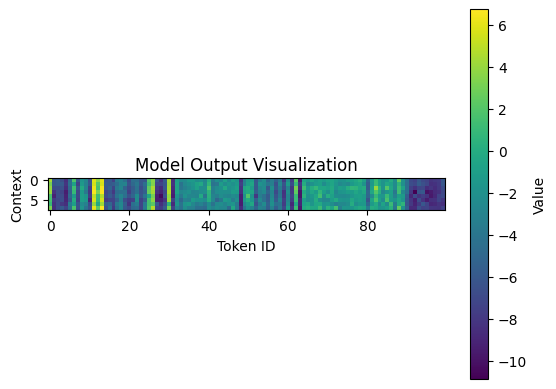

In [ ]:
# Visualize the models logits for some input text
test_text = "This looks less random than I was expecting"
new_tokens = tokenizer(test_text, return_tensors="pt")
x = new_tokens['input_ids'][0]
print(x)
print(x.shape)
with torch.no_grad():
    output = model(x)
print(output.shape)

# Organize plot
plt.imshow(output.detach().numpy()[:, :100], cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")
plt.title("Model Output Visualization")
plt.xlabel("Token ID")
plt.ylabel("Context")
plt.show()